# 1 Imports


In [2]:
import datetime
import inflection
import numpy as np
import pandas as pd
import seaborn as sns 

from matplotlib import pyplot as plt
pd.options.display.float_format = '{:.2f}'.format


In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
    %matplotlib inline
    %pylab inlin

# 2 File Reading


In [4]:
path = '../eda_rossmann/data/train.csv'
path1 = '../eda_rossmann/data/store.csv'
df_sales_raw = pd.read_csv(path)
df_store_raw = pd.read_csv(path1)


C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\230633613.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sales_raw = pd.read_csv(path)


# 3 Merge of Datasets, Rename Columns





## 3.1 Merge of Datasets



In [5]:
df = df_sales_raw.merge(df_store_raw, how='left', on='Store')

## 3.2 Rename Columns


In [6]:
col_old_names = df.columns
snake_case = lambda x: inflection.underscore(x)
cols_new_names = list(map(snake_case,col_old_names))
df.columns = cols_new_names

# 4 Data Description


## 4.1 Rows Filtering and Cols Drop



### 4.1.1 Rows Filtering

In [7]:
df1 = df[(df['sales'] > 0) & (df['open'] != 0)].copy()



### 4.1.2 Cols Drop

In [8]:
cols_drop = ['customers', 'open', 'promo_interval']
df1 = df1.drop(cols_drop, axis=1)



## 4.2 Data Dimension 


In [9]:
print(f'The number of rows is: {df1.shape[0]}')
print(f'The number of columns is: {df1.shape[1]}')



The number of rows is: 844338
The number of columns is: 15


## 4.3 Check and Change Data Types Before NA Treatment


In [10]:
df1.dtypes
df1['date']  = pd.to_datetime(df['date'])




### 4.3.1 Check NA


In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2186
competition_open_since_month    268600
competition_open_since_year     268600
promo2                               0
promo2_since_week               423292
promo2_since_year               423292
dtype: int64

## 4.4 NA Treatment

In [12]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if pd.isna(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if pd.isna(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1 )

df1['competition_distance'] = df1.apply(lambda x: 20000 if 
                                        pd.isna(x['competition_distance'])
                                        else x['competition_distance'], axis = 1)

df1['promo2_since_week'] = df1['promo2_since_week'].fillna(0)
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(0)


## 4.5 Check Data Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
dtype: object

# 4.6 Change Data Types

In [14]:

df1['sales'] = df1['sales'].astype(float)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

# 5 Descriptive Stats

<Axes: xlabel='assortment', ylabel='sales'>

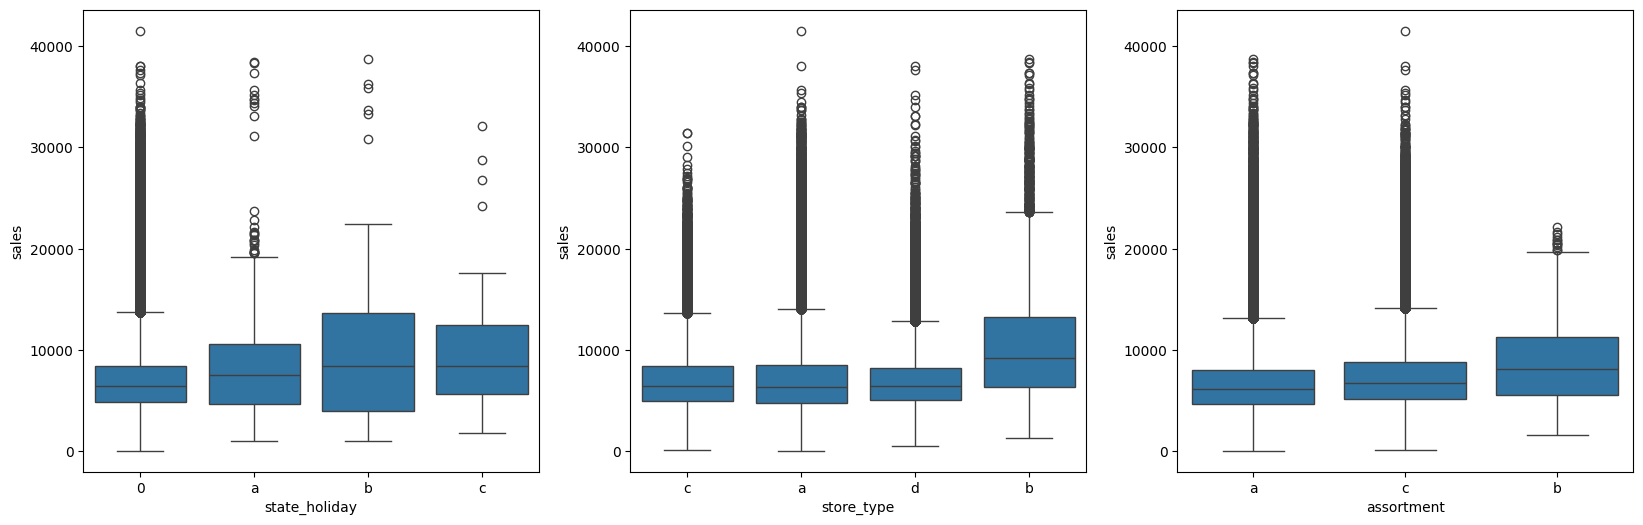

In [73]:
figsize=(20,6)
plt.figure(figsize=figsize)

df2 = df1.copy()


# Separate Categorical and Numerical Features
num_features = df2.select_dtypes(include=['int', 'float'])
cat_features = df2.select_dtypes(exclude=['int','float', 'datetime64'])

# Descriptive Stats for Numerical Features
num_features.describe().T


#Descriptive Stats for Categorical Features

# Count of Unique Elements for Each Feature
cat_features.apply(lambda x: x.unique().shape[0])

aux = df2[df2['state_holiday'] != 0]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux)

# The data is too disperse. The number of outliers is pretty high.


# 6 Feature Engineering

In [16]:
df3 = df2.copy()


# Year
df3['year'] = df3['date'].dt.year

# Month
df3['month'] = df3['date'].dt.month

# Day
df3['day'] = df3['date'].dt.day

# Weel of Year
df3['week_of_year'] = df3['date'].dt.strftime( '%Y-%W' )

# Assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' 
                                            else 'extra' if x == 'b'
                                            else 'extended')

# State Holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if 
                                                  x == 'a'
                                                  else 'easter_holiday' 
                                                  if x == 'b'
                                                  else 'christmas'
                                                  if x == 'c'
                                                  else 'regular_day')


# 7 EDA 

In [17]:

df4 = df3.copy()



## 7.1 Hipothesis 


In [18]:

# Stores with more assortment should sell more
# Stores with closer competitors should sell less
# Stores with old competitors should sell more
# Stores with long time promotions should sell more
# Stores with more consecutive promotion days should sell more
# Stores open on christmas should sell more
# Stores should sell more over the years
# Stores should sell more on the second semester
# Stores should sell more after day 10
# Stores should sell less on 
# Stores should sell less on student holidays



## 7.2 Univariate Analysis


### 7.2.1 Response Variable


<Figure size 2000x600 with 0 Axes>

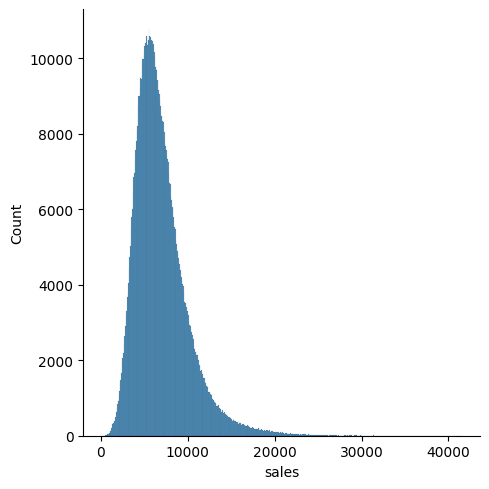

In [74]:
figsize=(20,6)
plt.figure(figsize=figsize)

sns.displot(df4['sales'])


### 7.2.2 Numerical Variables

<Figure size 1000x600 with 0 Axes>

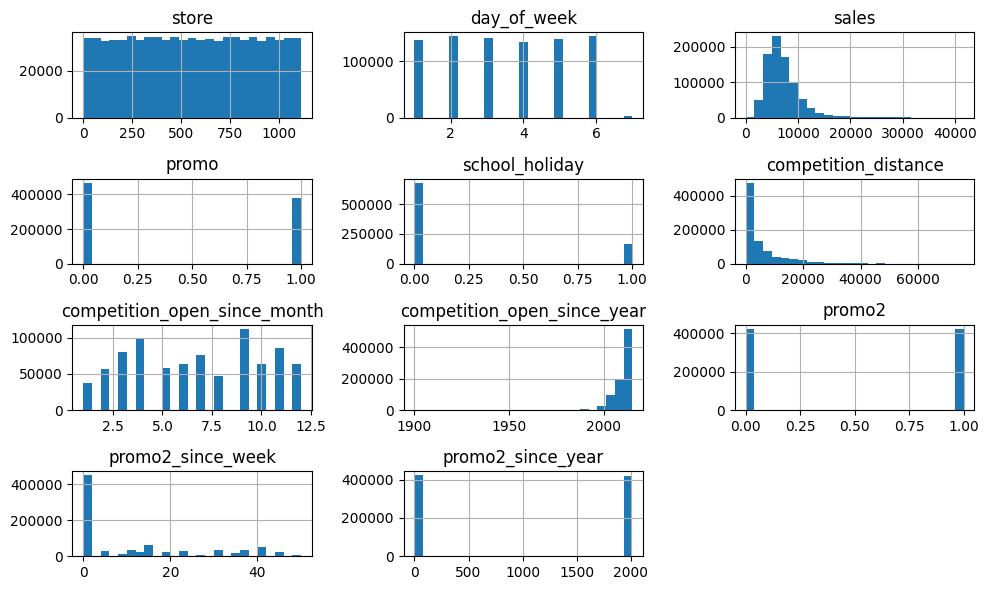

In [76]:
figsize=(10,6)
plt.figure(figsize=figsize)

num_features.hist(bins=25, figsize=figsize, layout=(4, 3))
plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

### 7.2.3 Categorical Variables

C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\3379815880.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\3379815880.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\3379815880.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas'] ['sales'],
C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\3379815880.py:23: FutureWarning: 

`shade` is now deprecated in favor 

<Axes: xlabel='sales', ylabel='Density'>

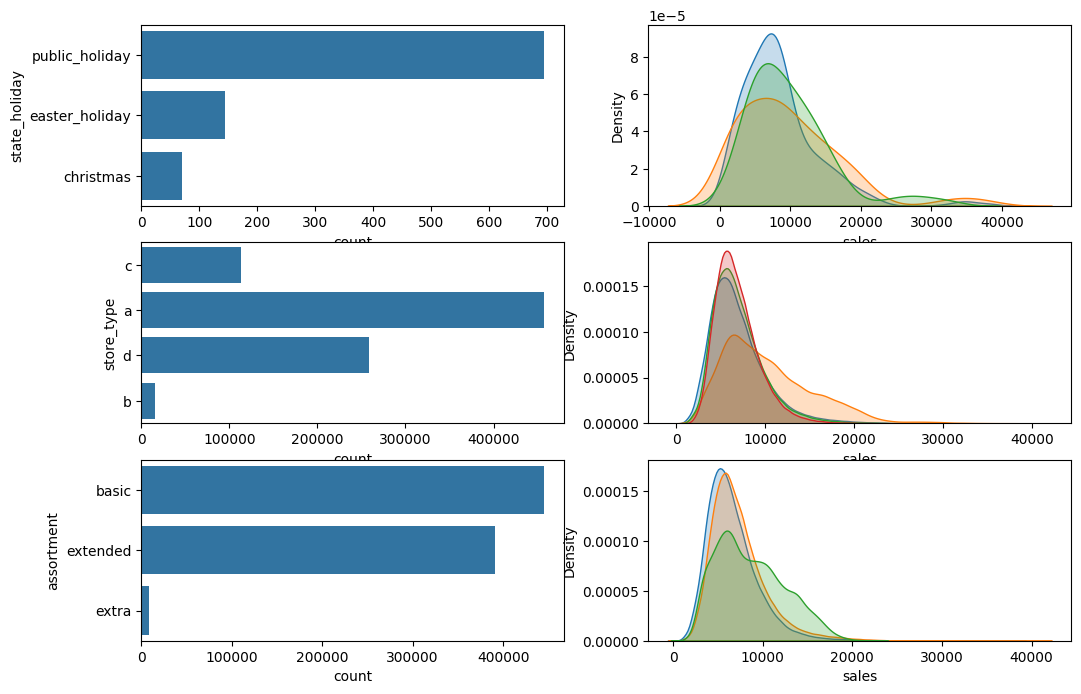

In [52]:
figsize=(12,8)
plt.figure(figsize=figsize)

# State Holiday
plt.subplot(3,2,1)
aux1 = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(aux1['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday'] ['sales'], 
            label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday'] ['sales'], 
            label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas'] ['sales'], 
            label = 'christmas', shade=True)


# Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a'] ['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b'] ['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c'] ['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd'] ['sales'], label = 'd', shade=True)

# Assortment 
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic'] ['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended'] ['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra'] ['sales'], label = 'extra', shade=True)


## 7.3 Bivariate Analysis

### 7.3.1 Stores with more assortment should sell more

### False: Stores with more assortment does not sell more

<Axes: xlabel='assortment', ylabel='sales'>

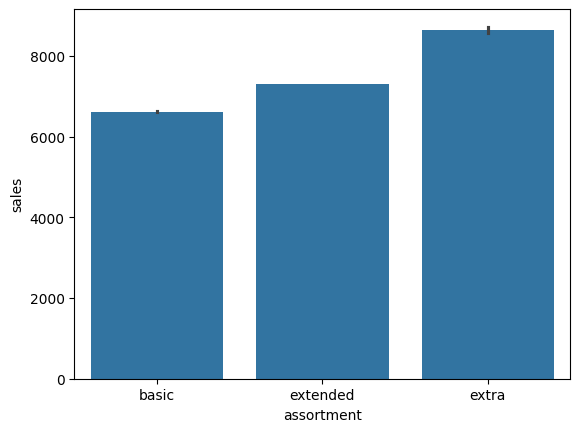

In [22]:
sns.barplot(x=df4['assortment'], y=df4['sales'], data=df4)

<Axes: xlabel='week_of_year'>

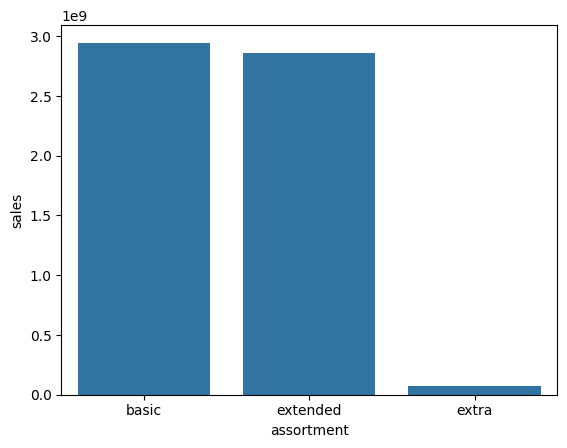

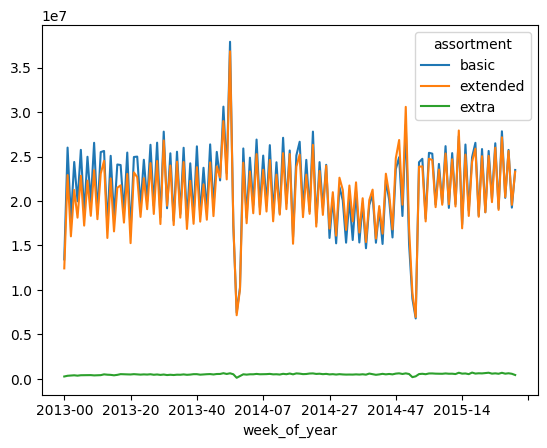

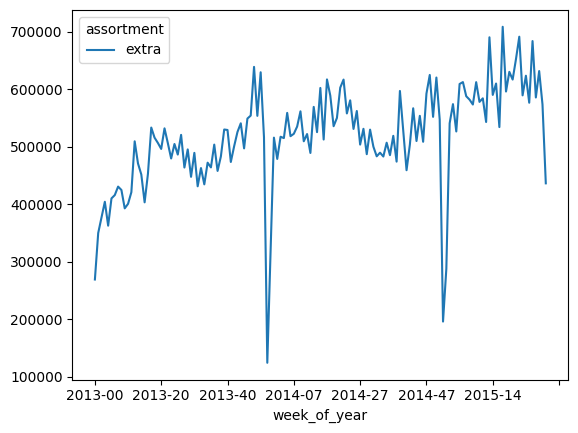

In [23]:
assortment_grouped = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data = assortment_grouped)

assortment_grouped_week = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year', 'assortment']).sum().reset_index()
# Pivot the data to create a column to each type of assortment, which will be the lines of the plot
assortment_grouped_week.pivot(index='week_of_year', columns='assortment',values='sales').plot()

assortment_extra_grouped = assortment_grouped_week[assortment_grouped_week['assortment'] == 'extra']
assortment_extra_grouped.pivot(index='week_of_year', columns='assortment', values='sales').plot()





### 7.3.2 Stores with closer competitors should sell less

### False: Stores with closer competitors sell more

In [24]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year'],
      dtype='object')

Axes(0.125,0.11;0.227941x0.77)


C:\Users\Thales\AppData\Local\Temp\ipykernel_9652\1119047162.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  competition_distance_bins_grouped = competition_distance_grouped[['competition_distance_binned', 'sales']].groupby(


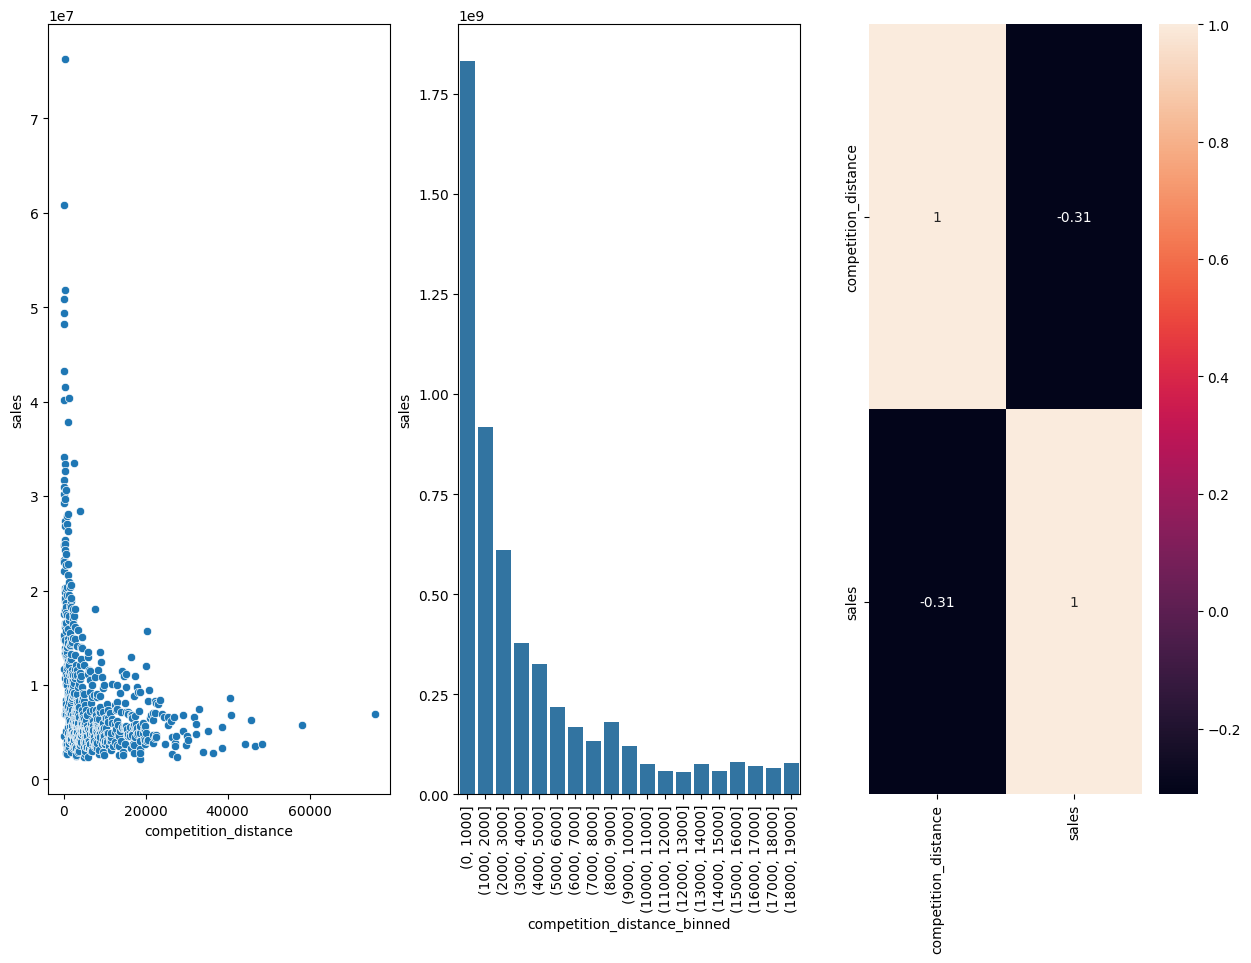

In [54]:
figsize=(15,10)
plt.figure(figsize=figsize)

plt.subplot(1,3,1)
competition_distance_grouped = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
print(sns.scatterplot(x='competition_distance', y='sales', data=competition_distance_grouped))

bins = list(np.arange(0,20000,1000)) # Create bins
competition_distance_grouped['competition_distance_binned'] = pd.cut(competition_distance_grouped
                                                                     ['competition_distance'],
                                                                     bins=bins)

plt.subplot(1,3,2)
competition_distance_bins_grouped = competition_distance_grouped[['competition_distance_binned', 'sales']].groupby(
                                    'competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=competition_distance_bins_grouped)
plt.xticks(rotation=90)
            

plt.subplot(1,3,3)
sns.heatmap(competition_distance_grouped[['competition_distance','sales']].corr(method='pearson'), annot=True)            
plt.xticks(rotation=90);
                                    

### 7.3.3 Stores with older competitors should sell more

### False: Stores with older competitors sell less

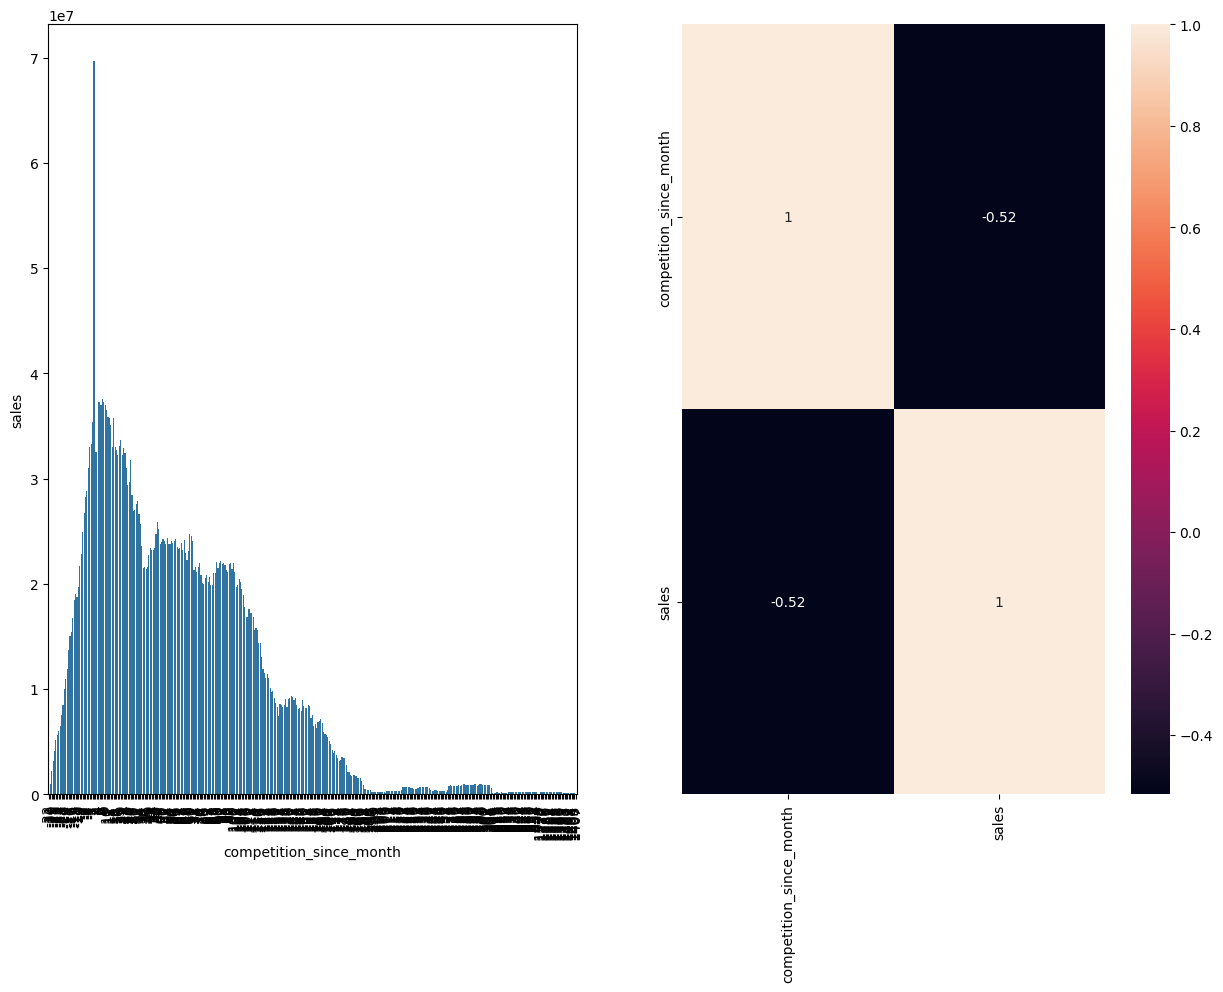

In [55]:
figsize=(15,10)
plt.figure(figsize=figsize)

df4['competition_since'] = df4.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'],
                                     month= x['competition_open_since_month'], day=1),axis=1) 
df4['competition_since_month'] = ((df4['date'] - df4['competition_since']) / 30).dt.days
df4[['competition_since_month', 'competition_since','date']].min() # Passar isso para a secao de feature engineering

# Stores with older competitors should sell more

competition_since_filtered = df4[df4['competition_since_month'] != 0]
competition_since_grouped = competition_since_filtered[['competition_since_month', 'sales']].groupby(
                            'competition_since_month').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='competition_since_month', y='sales', data=competition_since_grouped )
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.heatmap(competition_since_grouped[['competition_since_month','sales']].corr(method='pearson'), annot=True)            
plt.xticks(rotation=90);
                            


### 7.3.4 Stores with long time promotions should sell more


In [27]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'competition_since', 'competition_since_month'],
      dtype='object')

### 7.3.5 Stores with more consecutive promotion days should sell more

### False: Stores with more consecutive promotion days sell less

In [28]:
df4[['promo', 'promo2', 'sales']].groupby(['promo2', 'promo']).sum(    
 ).reset_index().sort_values(by='sales', ascending=False)

,promo2,promo,sales
1,0,1,1628930532.00
0,0,0,1482612096.00
3,1,1,1472275754.00
2,1,0,1289362241.00


In [29]:
df4['promo2_active'] = df4.apply(lambda x: 1 if (x['promo'] == 1) & (x['promo2'] == 1 ) else 0, axis=1)


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136],
 [Text(0, 0, '2013-00'),
  Text(1, 0, '2013-01'),
  Text(2, 0, '2013-02'),
  Text(3, 0, '2013-03'),
  Text(4, 0, '2013-04'),
  Text(5, 0, '2013-05'),


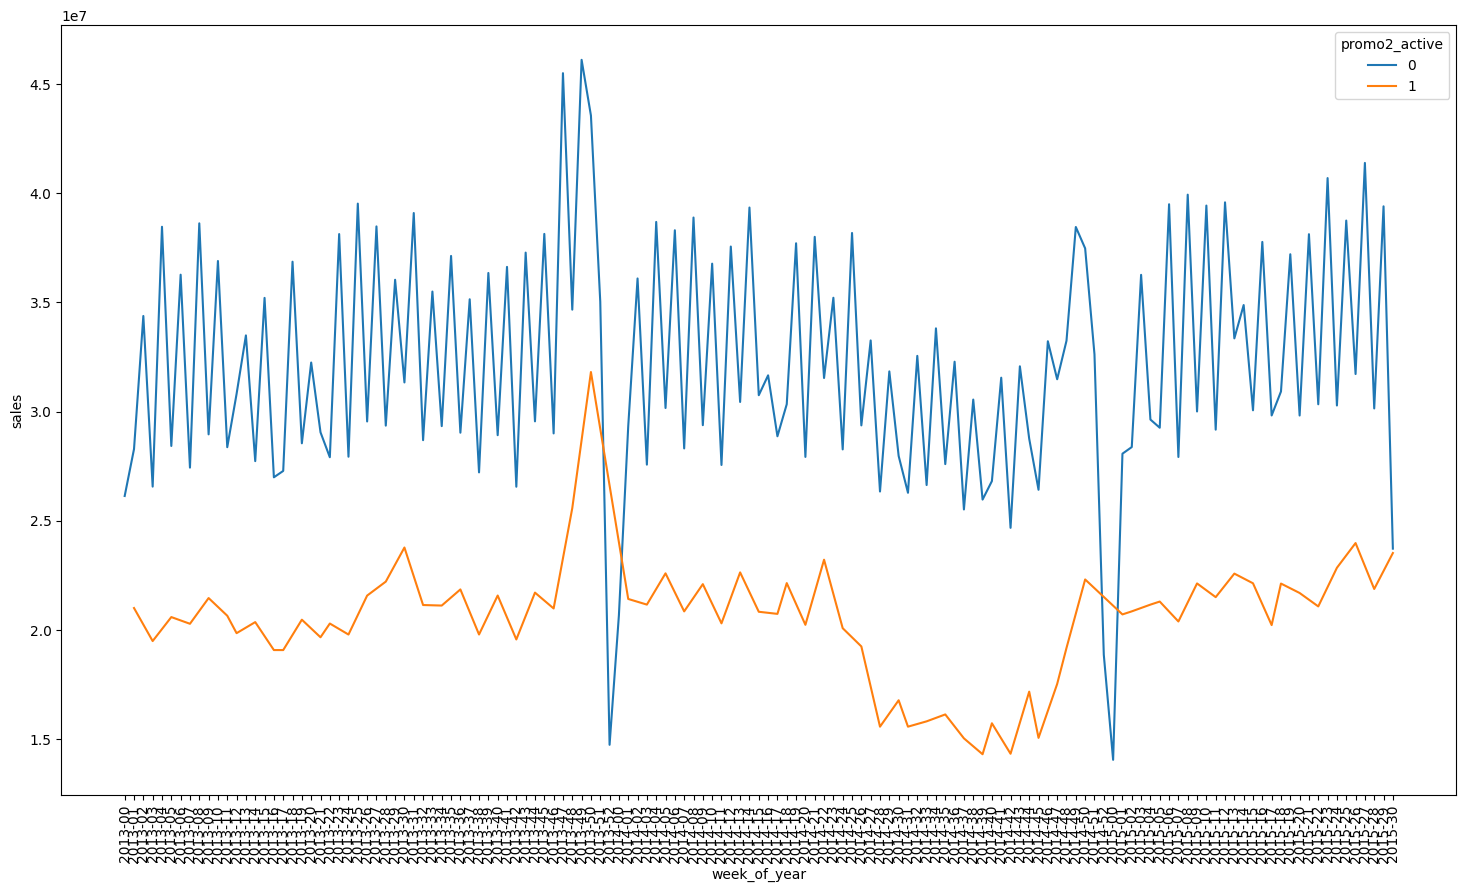

In [57]:
figsize=(18,10)
plt.figure(figsize=figsize)

promo2_active_grouped = df4[['promo2_active','week_of_year', 'sales']].groupby(
                            ['week_of_year', 'promo2_active']).sum().reset_index()


sns.lineplot(data=promo2_active_grouped, x='week_of_year', y='sales', hue='promo2_active' ) 
plt.xticks(rotation=90)        

### 7.3.6 Stores open on christmas should sell more

### False: Stores open on christmas should sell less


<Axes: xlabel='year', ylabel='sales'>

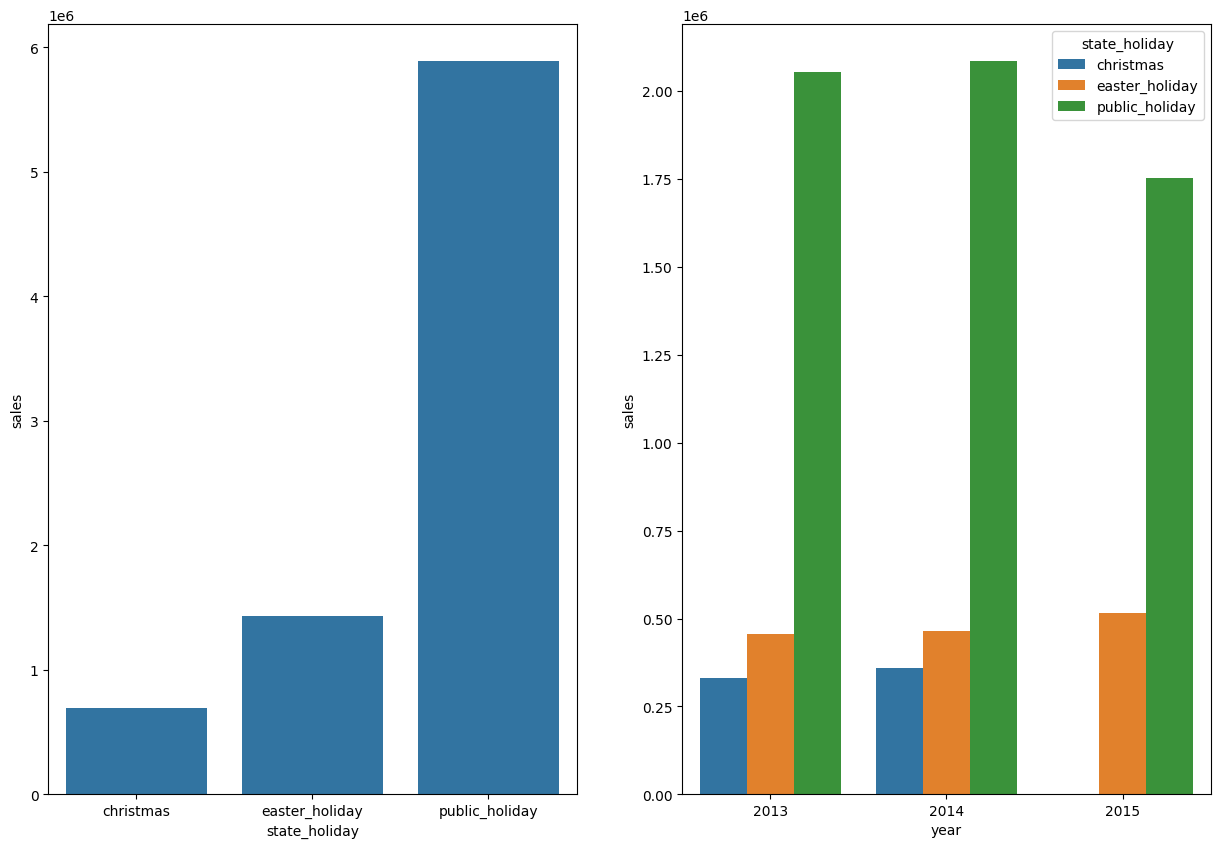

In [58]:
figsize=(15,10)
plt.figure(figsize=figsize)

holidays_filtered = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
holidays_grouped = holidays_filtered[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=holidays_grouped)

plt.subplot(1,2,2)
holidays_grouped_year = holidays_filtered[['state_holiday', 'sales', 'year']].groupby(['state_holiday', 'year']
                        ).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=holidays_grouped_year)

### 7.3.7 Stores should sell more over the years

### False: Stores sell less over the years


<Axes: >

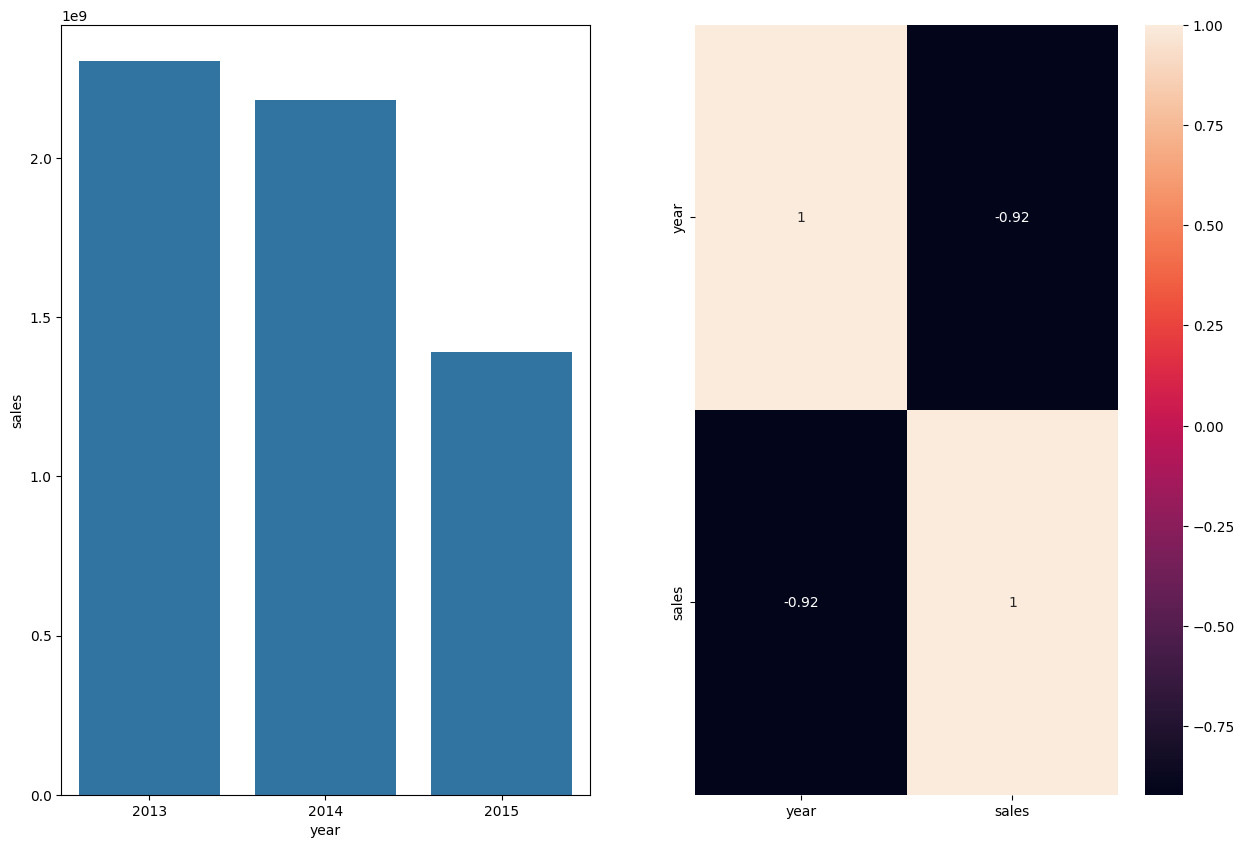

In [59]:
figsize=(15,10)
plt.figure(figsize=figsize)

sales_year_grouped = df4[['sales', 'year']].groupby('year').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='year', y='sales', data=sales_year_grouped)

plt.subplot(1,2,2)
sns.heatmap(sales_year_grouped.corr(method='pearson'), annot=True)


### 7.3.8 Stores should sell more on the second semester

### False: Stores sell less on the second semester
 


<Axes: >

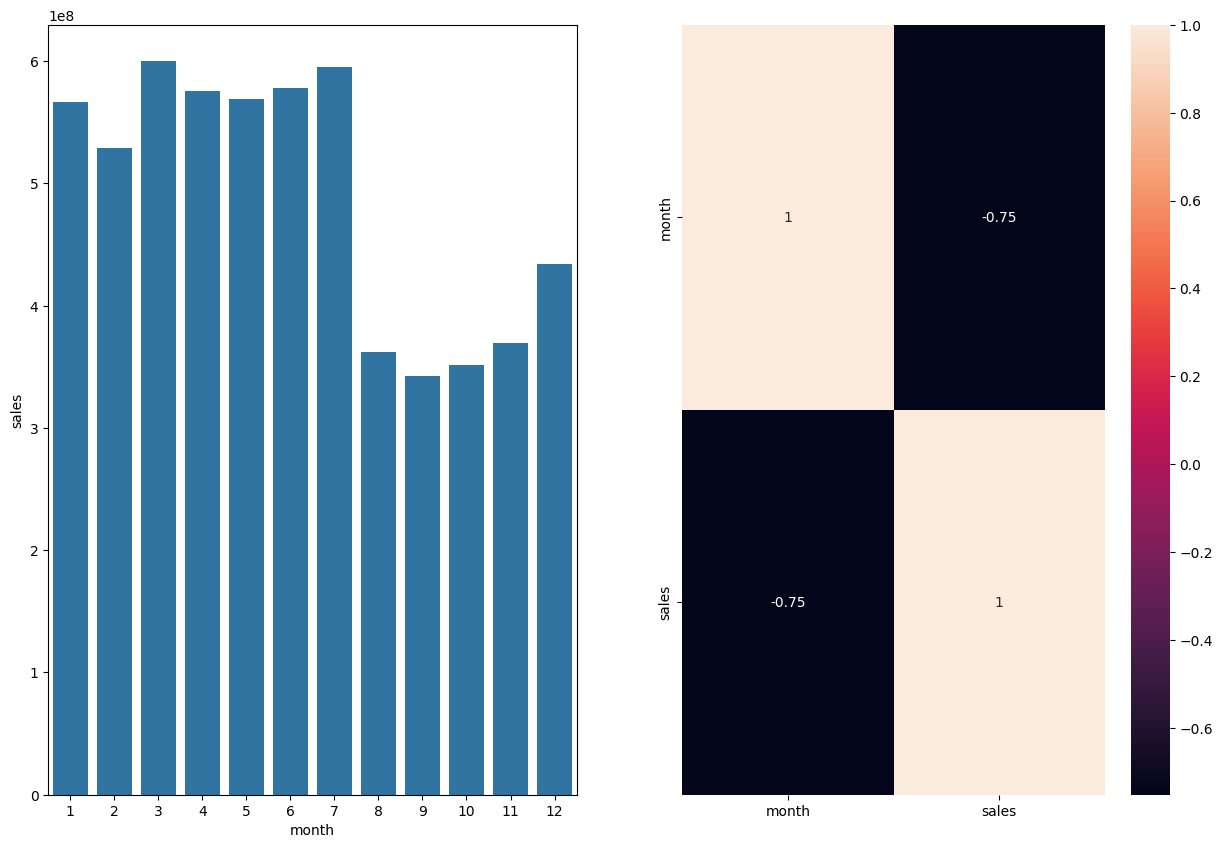

In [60]:
figsize=(15,10)
plt.figure(figsize=figsize)

sales_month_grouped = df4[['sales', 'month']].groupby('month').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='month', y='sales', data=sales_month_grouped)

plt.subplot(1,2,2)
sns.heatmap(sales_month_grouped.corr(method='pearson'), annot=True)


### 7.3.9 Stores should sell more after day 10

### False: Stores sell less after day 10


<Axes: >

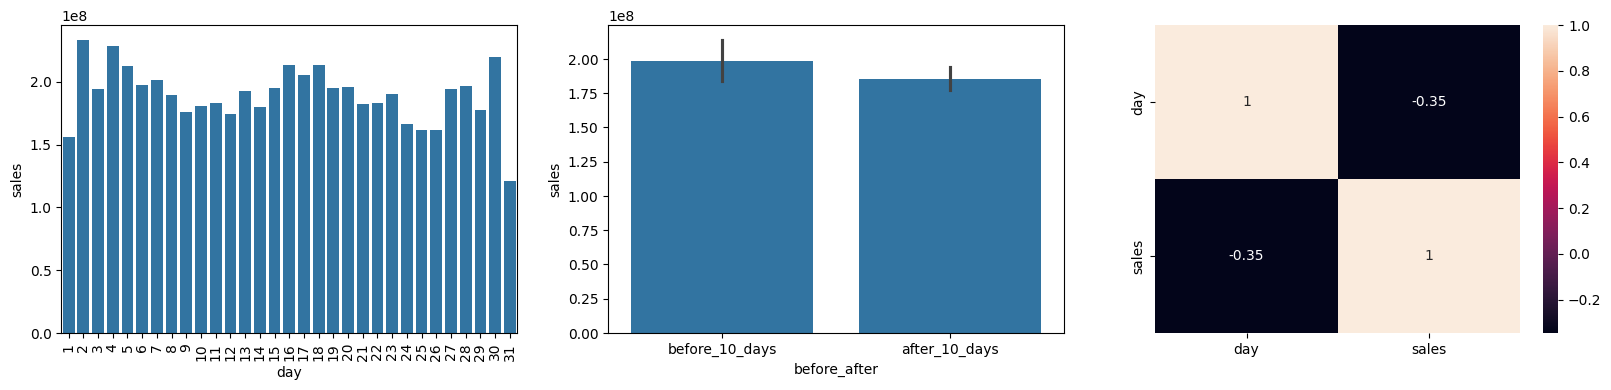

In [65]:
figsize=(20,4)
plt.figure(figsize=figsize)

plt.subplot(1,3,1)
sales_day_grouped = df4[['day','sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=sales_day_grouped)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sales_day_grouped['before_after'] = sales_day_grouped['day'].apply(
                                    lambda x: 'before_10_days' if x < 10 else 'after_10_days')

sns.barplot(x='before_after', y='sales', data=sales_day_grouped)


plt.subplot(1,3,3)
sns.heatmap(sales_day_grouped[['day', 'sales']].corr(method='pearson'), annot=True)


### 7.3.10 Stores should sell less on weekends

### True: Stores sell less on weekends

<Axes: >

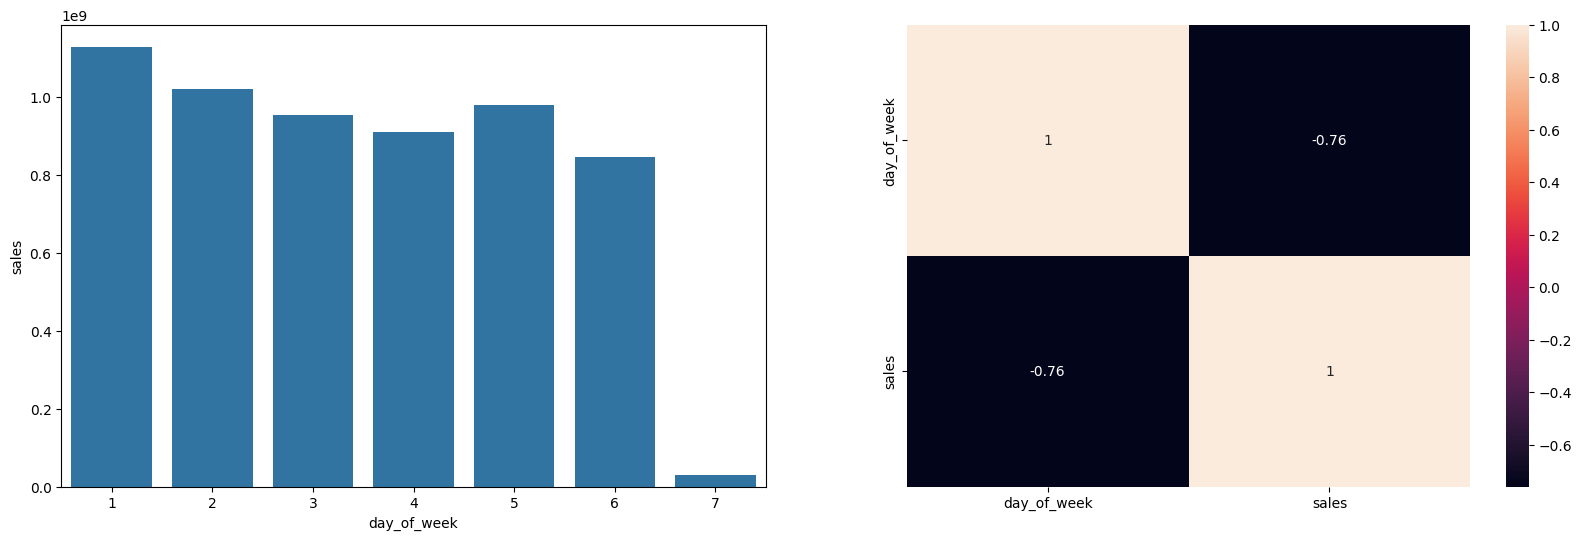

In [72]:
figsize=(20,6)
plt.figure(figsize=figsize)


day_of_week_grouped = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='day_of_week', y='sales', data=day_of_week_grouped)


plt.subplot(1,2,2)
sns.heatmap(day_of_week_grouped.corr(method='pearson'), annot=True)


### 7.3.11 Stores should sell less on student holidays

### True: Stores sell less on student holidays

<Axes: xlabel='school_holiday', ylabel='sales'>

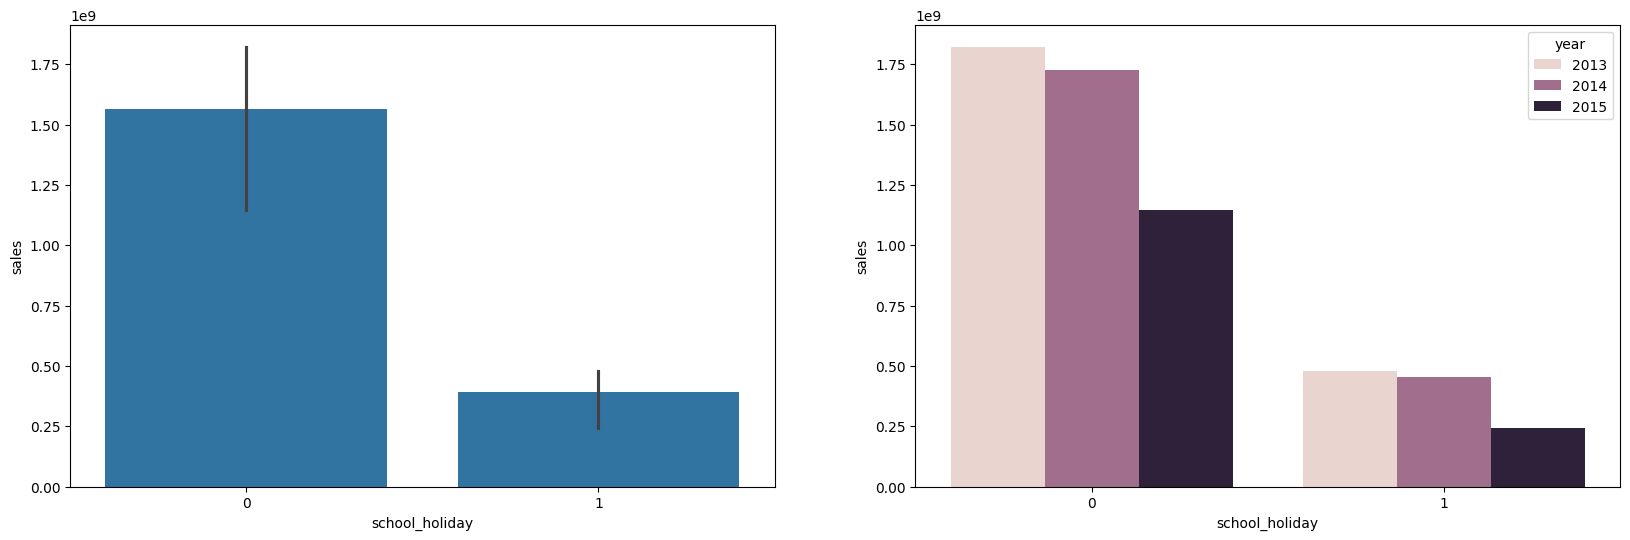

In [70]:
figsize=(20,6)
plt.figure(figsize=figsize)

school_holiday_grouped = df4[['school_holiday', 'sales', 'year']].groupby(['school_holiday','year']).sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='school_holiday', y='sales', data=school_holiday_grouped)

plt.subplot(1,2,2)
sns.barplot(x='school_holiday', y='sales', hue='year', data=school_holiday_grouped)





## 7.4 Multivariate Analysis


### 7.4.1 Numerical Features


<Axes: >

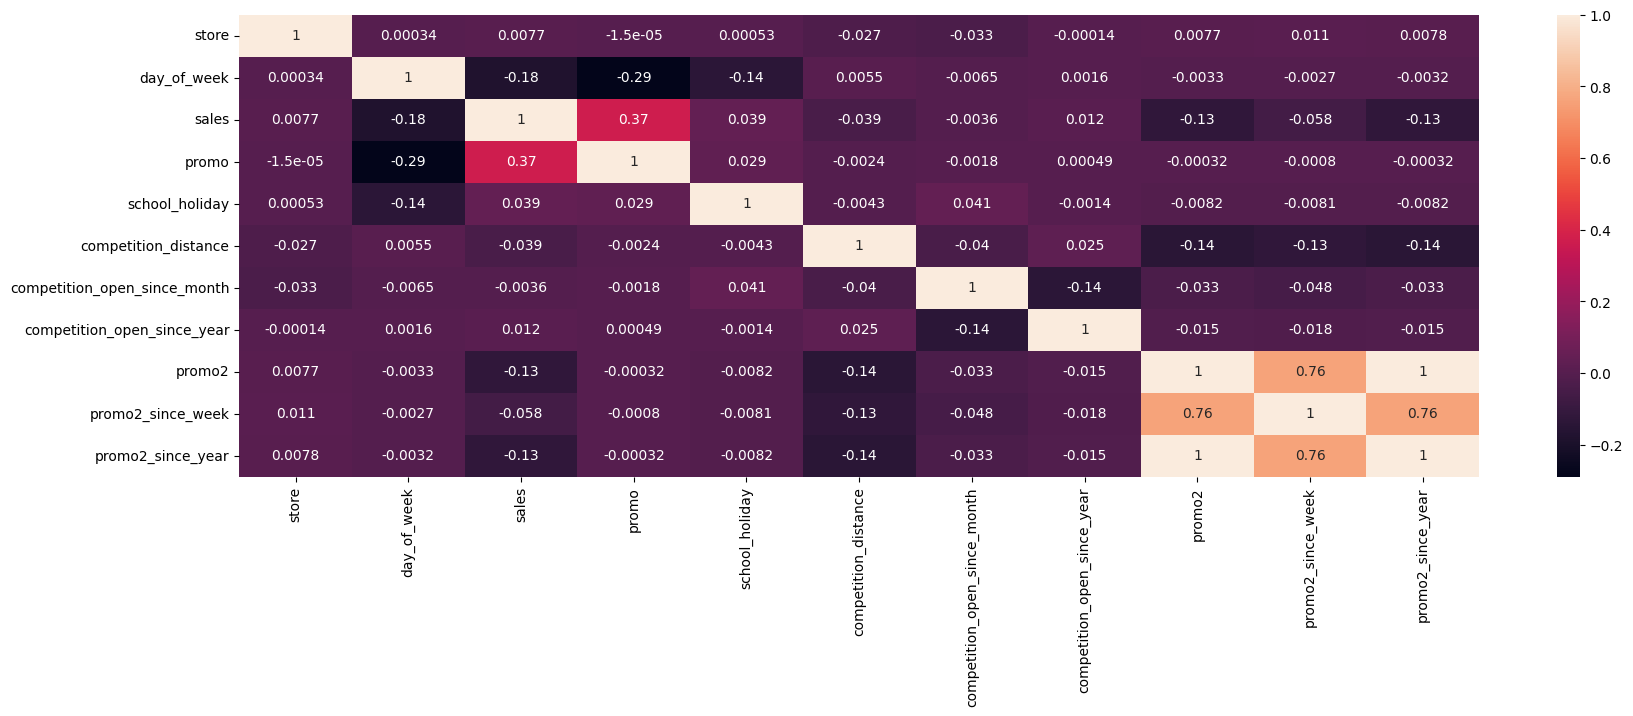

In [69]:
figsize=(20,6)
plt.figure(figsize=figsize)

sns.heatmap(num_features.corr(method='pearson'),annot=True)

### 7.4.2 Categorical Features

In [38]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [39]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['assortment'])
a3 = cramer_v(a['state_holiday'], a['store_type'])

a4 = cramer_v(a['assortment'], a['assortment'])
a5 = cramer_v(a['assortment'], a['state_holiday'])
a6 = cramer_v(a['assortment'], a['store_type'])

a7 = cramer_v(a['store_type'], a['store_type'])
a8 = cramer_v(a['store_type'], a['state_holiday'])
a9 = cramer_v(a['store_type'], a['assortment'])

cramer_v_df = pd.DataFrame({'state_holiday':[a1,a2,a3],
                            'assortment': [a4,a5,a6],
                            'store_type': [a7,a8,a9]})

cramver_v_df = cramer_v_df.set_index(cramer_v_df.columns)


sns.heatmap(craver_v_df, annot=True)



AttributeError: 'DataFrame' object has no attribute 'as_matrix'